# Path Planning For Robotic Manipulators

In this notebook we will consider the different algorithms for robotic manipulators path planning in 3-dimensional space with obstacles and compare their performaтce. We will compare `A*`, `RRT` and `KPIECE` algorithms. It's assumed that the slowest of them is `A*` (it's baseline), `RRT` is slightly faster and `KPIECE` is significantly faster. 

Robotic manipulator is represented as a polyline (segments of the polyline called arms, ends of segments called joints), each arm can be rotated in a fixed plane. The goal is to move the last joint to the finish area, minimizing sum of rotation angles and avoiding obstacles. The obstacles and finish area have a spherical shape.  

In [1]:
from typing import Optional, List, Tuple
import numpy as np
import scipy.stats as ss
from abc import ABC, abstractmethod
from heapq import heappop, heappush, heapify
import matplotlib.pyplot as plt

## Manipulator State Representation

In [2]:
class Manipulator():
    '''
    Manipulator class represents a manipulator state

    - joint_num: number of manipulator's joints
    - angle_delta: elementary angle of rotation (needed for proccess discretization)
    - joint_angles: angles, specifying the positions of each next joint relative to the previous one
    - arm_len: lengths of manipulator arms

    '''
    def __init__(self, 
        joint_num: int, 
        angle_delta: Optional[float] = np.pi / 180,
        joint_angles: Optional[List[float]] = None, 
        arm_len: Optional[List[float]] = None):
        assert (joint_num >= 3) 
        '''
        Initialization of manipulator state with custom (if any) or default parameters
        '''

        self.joint_num = joint_num
        self.angle_delta = angle_delta

        if joint_angles is None: 
            self.joint_angles = [0] + [np.pi] * (joint_num - 1)
        else: 
            self.joint_angles = joint_angles

        if arm_len is None: 
            self.arm_len = [1] * (joint_num - 1)
        else: 
            self.arm_len = arm_len
        
        self.joint_coordinates = None  # lazy init
        
    def get_joint_coordinates(self) -> np.ndarray: 
        '''
        Calculates the coordinates of joints for the current manipulator state
        '''
            
        if self.joint_coordinates is not None: 
            return self.joint_coordinates
        self.joint_coordinates = np.zeros((self.joint_num, 3))
        self.joint_coordinates[1] = np.array([
            self.arm_len[0] * np.cos(self.joint_angles[1]), 
            0, 
            self.arm_len[0] * np.sin(self.joint_angles[1])
        ])
        for i in range(1, self.joint_num - 1): 
            prev_arm_vec = self.joint_coordinates[i] - self.joint_coordinates[i - 1]
            new_arm_vec = prev_arm_vec / np.linalg.norm(prev_arm_vec) * self.arm_len[i]
            new_arm_vec[[0, 2]] = Manipulator.rotation_matrix_2d(np.pi + self.joint_angles[i + 1]) @ new_arm_vec[[0, 2]] 
            self.joint_coordinates[i + 1] = self.joint_coordinates[i] + new_arm_vec
        turn_around_rot = Manipulator.rotation_matrix_2d(self.joint_angles[0])
        for i in range(0, self.joint_num):
            self.joint_coordinates[i][[0, 1]] = turn_around_rot @ self.joint_coordinates[i][[0, 1]]
        return self.joint_coordinates

    def copy_with_new_angles(self, new_angles):
        '''
        Returns new manipulator: it almost equals to current manipulator, but with the new joint angles
        '''
        
        return Manipulator(
            self.joint_num,
            self.angle_delta,
            new_angles,
            self.arm_len,
        )

    def get_successors(self):
        '''
        Returns a list of possible successors (not necessarily valid) for the current manipulator state
        '''
        
        successors = []
        for i in range(self.joint_num):
            for dir in [-1, 1]:
                successors.append(self.apply(i, dir, self.angle_delta))
        return successors

    def apply(self, joint_ind, dir, dangle):
        '''
        Computes new manipulator state, obtained by rotating some arm of the manipulator
        
        Parameters
        ----------
        joint_ind : int
            index of joint, which is the end of rotating arm
        dir : int
            direction of rotation, 1 if counterclockwise, -1 if clockwise
        dangle : int
            angle of rotation
        '''
        
        new_joint_angle = self.joint_angles[joint_ind] + dangle * dir
        if new_joint_angle < 0:
            new_joint_angle += 2 * np.pi
        if new_joint_angle > 2 * np.pi:
            new_joint_angle -= 2 * np.pi
        return self.copy_with_new_angles(
            self.joint_angles[:joint_ind] + [new_joint_angle] + self.joint_angles[joint_ind + 1:]
        )

    def calc_raw_distance(self, point):
        '''
        Calculates euclidean distance between last joint of manipulator and a given point
        '''
        
        return ((self.get_joint_coordinates()[-1] - point) ** 2).sum()

    def calc_angle_distance(self, other):
        '''
        Calculates the sum of angles, by which manipulator arms should be rotated 
        to get the other manipulator state from the current one
        '''
        
        dsts = np.abs(np.array(self.joint_angles) - np.array(other.joint_angles))
        return np.minimum(dsts, 2 * np.pi - dsts).sum()

    @staticmethod
    def rotation_matrix_2d(angle: float) -> np.ndarray: 
        return np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])

## Obstacles Representation

In [3]:
class Obstacle(ABC):
    '''
    Interface of obstacle: provides a list of methods that must be implemented by each instance of obstacle
    '''
    
    @abstractmethod
    def intersect(self, manipulator: Manipulator) -> bool:
        pass


class SphereObstacle(Obstacle):
    '''
    Instance of obstacle with the spherical shape
    
    - center: coordinates of the sphere center
    - r: radius of sphere
    
    '''
    def __init__(self, center: np.ndarray, r: float): 
        '''
        Default constructor
        '''
        
        self.center = center
        self.r = r 

    def intersect(self, manipulator: Manipulator) -> bool:
        '''
        Determines whether obstacle intersects with the given manipulator (i.e. intersects with one of its arms)
        '''
        
        joint_coordinates = manipulator.get_joint_coordinates() 
        for i in range(len(joint_coordinates) - 1): 
            if np.linalg.norm(joint_coordinates[i] - self.center) < self.r or np.linalg.norm(joint_coordinates[i + 1] - self.center) < self.r: 
                return True
            arm_vec = joint_coordinates[i + 1] - joint_coordinates[i] 
            t = (self.center @ arm_vec - joint_coordinates[i] @ arm_vec) / (np.linalg.norm(arm_vec) ** 2)  # arm contains all points: joint_coordinates[i] + t * arm_vec, if t \in [0, 1]
            if 0 <= t <= 1 and np.linalg.norm(joint_coordinates[i] + arm_vec * t - self.center) < self.r:
                return True
        return False


## Map Representation

In [4]:
class Map:
    '''
    Map class represents environment for manipulator: obstancles and finish area description
    
    - obstacles: list of obstacles
    - finish: coordinates of the finish center
    - finish_size: finish size (in our case it's radius of sphere)
    
    '''

    eps = 1e-6

    def __init__(self, obstacles: List[Obstacle], finish: np.ndarray, finish_size):
        '''
        Default constructor
        '''

        self.obstacles = obstacles
        self.finish = finish
        self.finish_size = finish_size

    def valid(self, manipulator: Manipulator):
        '''
        Validates manipulator state: 
        returns true if manipulator does not intersect with any obstacle and
        all z-coordinates of joints are non-negative, false otherwise
        '''
        
        if manipulator.get_joint_coordinates()[:,2].min() < -Map.eps:
            return False

        for obs in self.obstacles:
            if obs.intersect(manipulator):
                return False
        return True

    def dist_to_finish(self, manipulator: Manipulator):
        '''
        Calculates euclidean distance between last joint of manipulator and center of the finish area
        '''
        
        return np.sqrt(((manipulator.get_joint_coordinates()[-1] - self.finish) ** 2).sum())

    def is_in_finish(self, manipulator: Manipulator):
        '''
        Determines whether last manipulator joint is in the finish area
        '''
        
        return self.dist_to_finish(manipulator) < self.finish_size

## Search Node Representation

In [5]:
class Node:
    '''
    Node class represents a search node

    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node

    '''
    eps = 1e-6

    def __init__(self, state: Manipulator, g=0, h=0, f=None, parent=None):
        self.state = state
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other: Manipulator):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        angles1 = np.array(self.state.joint_angles)
        angles2 = np.array(other.joint_angles)
        return np.abs(angles1 - angles2).max() < Node.eps

    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        return hash(str([int(angle / self.eps) for angle in self.state.joint_angles]))

    def __lt__(self, other):
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        '''
        if self.f == other.f:
            return self.g > other.g

        return self.f < other.f

## Search tree for A*

Efficient non list-based implementation of the search tree for `A*` algorithm. Here `OPEN` is a heap in order to extracts the best node rapidly and `CLOSED` is a set, because we should check as fast as possible whether node was expanded. This implementation handling dublicates lazily. 

In [6]:
class DefaultSearchTree:
    def __init__(self):
        self._open = []       # heap for the OPEN nodes  
        self._closed = set()  # set for the expanded nodes = CLOSED

    def __len__(self):
        return len(self._open) + len(self._closed)

    def open_is_empty(self):
        return len(self._open) == 0
    
    def add_to_open(self, item):
        '''
        Adds a (previously not expanded) node to the search-tree (i.e. to OPEN).
        It's either a totally new node (the one we never encountered before)
        or a dublicate of the node that currently resides in OPEN.
        '''
        
        heappush(self._open, item)

    def get_best_node_from_open(self):
        '''
        Extracts the best node (i.e. the one with the minimal f-value) from OPEN.
        This node will be expanded further on in the main loop of the search.
        '''
        
        while len(self._open) > 0:
            item = heappop(self._open)
            if not self.was_expanded(item):
                return item
        return None


    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open

    @property
    def CLOSED(self):
        return self._closed


## A* Implementation

By default, we will use the following heuristic: let's denote the distance between finish and last joint of the manipulator by `dist`. We need to deliver the last joint to the finish, moving along the arcs of some circles. Note, that the larger the radius of the circle, the smaller the rotation angle for moving between two fixed points. At each moment of time, radius of circle is at most sum of manipulator arm lengths. Let's denote this sum by `r`.

Now, having `dist` and `r` we can get the inequality for sum of rotation angles using cosine theorem.

In [7]:
def default_heuristic_func(manipulator, finish):
    coordinates = manipulator.get_joint_coordinates()
    dist = np.linalg.norm(manipulator.get_joint_coordinates()[-1] - finish)
    r = np.sum(manipulator.arm_len)

    if dist > 2 * r:
        return np.pi

    return np.arccos(1 - dist ** 2 / (2 * r ** 2))

In [8]:
def astar(initial_state: Manipulator, map: Map, heuristic_func=default_heuristic_func, search_tree=DefaultSearchTree):
    ast = search_tree()
    ast.add_to_open(Node(initial_state, h=heuristic_func(initial_state, map.finish)))

    last_node = None
    while not ast.open_is_empty():
        current_node = ast.get_best_node_from_open()
        if current_node is None:
            break

        if map.is_in_finish(current_node.state):
            last_node = current_node
            break

        for next_state in current_node.state.get_successors():
            if not map.valid(next_state):
                continue

            next_node = Node(
                next_state, 
                g=current_node.g + current_node.state.calc_angle_distance(next_state), 
                h=heuristic_func(next_state, map.finish),
                parent=current_node
            )

            if not ast.was_expanded(next_node):
                ast.add_to_open(next_node)


    return last_node

## RRT Implementation

In [9]:
def _gen_random_state(manip: Manipulator, map: Map) -> Manipulator:
    new_state = None
    while new_state is None or not map.valid(new_state):
        new_state = manip.copy_with_new_angles(np.random.rand(manip.joint_num) * 2 * np.pi)
    return new_state

In [10]:
def rrt(manip: Manipulator, map: Map):
    nodes = [Node(manip)]
    
    while True:
        new_state = _gen_random_state(manip, map)
        prv = nodes[0]
        
        for node in nodes:
            if new_state.calc_angle_distance(node.state) < new_state.calc_angle_distance(prv.state):
                prv = node

        best_approx = None
        for succ in prv.state.get_successors():
            
            if map.valid(succ) and (best_approx is None or succ.calc_angle_distance(new_state) < best_approx.calc_angle_distance(new_state)):
                best_approx = succ
        

        if best_approx is None:
            continue

        new_node = Node(best_approx, prv.g + prv.state.calc_angle_distance(best_approx), parent=prv)
        nodes.append(new_node)
        
        if map.is_in_finish(best_approx):
            return new_node

## KPIECE Implementation

In [11]:
class Motion:
    def __init__(self, start_node: Node, joint: int, dir: int, dur_max: float):
        self.start_node = start_node
        self.joint = joint
        self.dir = dir
        self.dur_max = dur_max

In [12]:
class GridCell:
    def __init__(self, parent, coords: np.ndarray, motions: List[Motion] = None, inner_grid=None, iter=2, mindist=100, selection_rule='original'):
        self.parent = parent
        self.motions = motions
        self.coords = coords
        self.inner_grid = inner_grid
        self.iter = iter
        self.s = 1
        self.mindist = mindist
        self.selection_rule = selection_rule

    def importance(self):
        n = self.parent.cnt_neighbors(self)
        if self.motions is not None:
            c = len(self.motions)
        else:
            c = len(self.inner_grid.cells)
        if self.selection_rule == 'shortest':
            return 1 / self.mindist
        elif self.selection_rule == 'original':
            return np.log(self.iter) / (self.s * (n + 1) * c)
        elif self.selection_rule == 'mixed':
            return np.log(self.iter) / (self.s * (n + 1) * c * self.mindist)
        raise "wrong selection rule"

In [13]:
class Grid:
    eps = 1e-6
    bias = 0.8

    def __init__(self, level: int, lbounds: np.ndarray, edge_size: float, k: int, map: Map, selection_rule: str):
        self.level = level
        self.lbounds = lbounds
        self.edge_size = edge_size
        self.k = k
        self.d = len(lbounds)
        self.cells = []
        self.all_codes = set()
        self.map = map
        self.selection_rule = selection_rule

    def _add_motion(self, motion: Motion, cc: int):
        coords = np.floor_divide(motion.start_node.state.joint_angles - self.lbounds, self.edge_size)
        cell = None
        for elem in self.cells:
            if np.abs(elem.coords - coords).sum() < Grid.eps:
                cell = elem
                break
        if cell is None:
            cell = GridCell(self, coords, iter=cc, mindist=self.map.dist_to_finish(motion.start_node.state) ** 2)
            self.cells.append(cell)
            self.all_codes.add(self._coords_to_code(coords))
            if self.level > 1:
                cell.inner_grid = Grid(self.level - 1, self.lbounds + coords * self.edge_size, self.edge_size / self.k, self.k, self.map, self.selection_rule)
            else:
                cell.motions = []
        if self.level > 1:
            cell.inner_grid.add_motion(motion, cc)
        else:
            cell.motions.append(motion)
        cell.mindist = min(cell.mindist, self.map.dist_to_finish(motion.start_node.state) ** 2)

    def add_motion(self, motion: Motion, cc: int):
        coords = np.floor_divide(motion.start_node.state.joint_angles - self.lbounds, self.edge_size)
        init_pos = motion.start_node.state.joint_angles[motion.joint]
        if motion.dir == 1:
            tm_needed = self.lbounds[motion.joint] + self.edge_size * (coords[motion.joint] + 1) - init_pos
        else:
            tm_needed = init_pos - (self.lbounds[motion.joint] + self.edge_size * coords[motion.joint])

        assert tm_needed >= 0
        eps = 1e-4
        if tm_needed < motion.dur_max:
            dump_node = motion.start_node
            cntdump = round((tm_needed + eps) / motion.start_node.state.angle_delta) + 1
            for i in range(cntdump):
                dump_node = Node(dump_node.state.apply(motion.joint, motion.dir, (tm_needed + eps) / cntdump), dump_node.g + (tm_needed + eps) / cntdump, parent=dump_node)
            self._add_motion(Motion(motion.start_node, motion.joint, motion.dir, tm_needed - eps), cc)
            self.add_motion(Motion(dump_node, motion.joint, motion.dir, motion.dur_max - tm_needed - eps), cc)
        else:
            self._add_motion(motion, cc)

    def _coords_to_code(self, coords: List[int]):
        res = 0
        for elem in coords:
            res *= self.k
            res += elem
        return res

    def cnt_neighbors(self, cell: GridCell):
        cnt = 0
        for i in range(self.d):
            new_coords = cell.coords.copy()
            new_coords[i] = (new_coords[i] + 1) % self.k
            if self._coords_to_code(new_coords) in self.all_codes:
                cnt += 1
            new_coords[i] = (cell.coords[i] - 1 + self.k) % self.k
            if self._coords_to_code(new_coords) in self.all_codes:
                cnt += 1
        return cnt

    def _split_int_ext(self):
        interior, exterior = [], []
        for elem in self.cells:
            if self.cnt_neighbors(elem) == self.d * 2:
                interior.append(elem)
            else:
                exterior.append(elem)
        return interior, exterior

    def select_motion(self) -> Tuple[Motion, GridCell]:
        interior, exterior = self._split_int_ext()
        if np.random.rand() < Grid.bias:
            cells = exterior
        else:
            cells = interior

        if len(cells) == 0:
            cells = self.cells

        best = None
        for elem in cells:
            if best is None or elem.importance() > best.importance():
                best = elem
        best.s += 1
        if self.level > 1:
            return best.inner_grid.select_motion()

        sz = len(best.motions)
        ind = min(sz - 1, int((ss.halfnorm(scale=sz/6).rvs())))
        return best.motions[max(sz - ind - 1, 0)], best

In [14]:
def kpiece(manip: Manipulator, map: Map, grid_k=2, lvls=None, selection_rule='mixed'):
    if lvls is None:
        lvls = np.ceil(np.log(2 * np.pi / 0.1) / np.log(grid_k))
    grid = Grid(lvls, np.zeros(manip.joint_num), edge_size=2*np.pi/grid_k, k=grid_k, map=map, selection_rule=selection_rule)
    start_node = Node(manip)
    grid.add_motion(Motion(start_node, 0, 1, 0.0001), 2)
    cc = 1
    while True:
        cc += 1
        motion, cell = grid.select_motion()
        t = np.random.rand() * motion.dur_max
        nxt_state = motion.start_node.state.apply(motion.joint, motion.dir, t)
        nxt_node = Node(nxt_state, motion.start_node.g + t, parent=motion.start_node)
        joint_ind = np.random.randint(0, manip.joint_num)
        dir = 1
        if np.random.rand() > 0.5:
            dir = -1
        max_dur = 0
        dump_node = nxt_node
        while max_dur + manip.angle_delta < np.pi:
            after_move = nxt_state.apply(joint_ind, dir, max_dur + manip.angle_delta)
            dump_node = Node(after_move, dump_node.g + manip.angle_delta, parent=dump_node)
            if not map.valid(after_move):
                break
            if map.is_in_finish(after_move):
                return dump_node
            max_dur += manip.angle_delta

        if max_dur > 0:
            grid.add_motion(Motion(nxt_node, joint_ind, dir, max_dur), cc)

## Tests Generation

In [15]:
def gen_random_manipulator(joint_num: int) -> Manipulator: 
    '''
    Generates a manipulator with random joints angles by number of joints.
    Lengths of all arms equals to one.
    '''
    
    while (True):
        angles = ss.uniform(0, 2 * np.pi).rvs(size=1).tolist() + ss.uniform(0, np.pi).rvs(size=1).tolist() + ss.uniform(0, 2 * np.pi).rvs(size=joint_num - 2).tolist() 
        manipulator = Manipulator(
joint_num=joint_num, joint_angles=angles)
        if np.all(manipulator.get_joint_coordinates()[:, 2] > -eps): 
            return manipulator

In [16]:
class ManipulatorTest:
    def __init__(self,
        init_manipulator: Manipulator,
        goal_point: np.ndarray, 
        obstacles: List[Obstacle],
        ) -> None:
        self.init_manipulator = init_manipulator
        self.goal_point = goal_point 
        self.obstacles = obstacles

In [17]:
eps = 1e-9

def generate_test(
    joint_num: int, 
    obstacles_num: int,
    sigma: float = 0.5, 
    size: float = 0.5,
    scale: float = 0.25,
    type: str = 'onway',
) -> ManipulatorTest: 
    '''
    Generates random goal, manipulator and obstacles. 
    For obstacles there are two modes of generation:
        - onway mode corresponds to obstacles on way between 0 and goal
        - random mode corresponds to obstacles in random parts of map
    '''
    
    goal = ss.uniform(0.1, joint_num / 2 - 0.1).rvs(size=3) * np.random.choice([-1, 1], 3)
    goal[2] = np.abs(goal[2])
    obstacles = []
    for _ in range(obstacles_num): 
        if type == 'onway':
            obstacle_noise = ss.norm(loc=0, scale=sigma).rvs(size=3)
            obstacle_center = goal * ss.uniform(0.1, 0.8).rvs(size=1) + obstacle_noise
        elif type == 'random': 
            obstacle_center = ss.uniform(0.1, joint_num / 2 - 0.1).rvs(size=3) * np.random.choice([-1, 1], 3)
        else: 
            raise RuntimeError('not implemented')
            
        r_bound = min(np.linalg.norm(obstacle_center), np.linalg.norm(goal - obstacle_center))
        r = ss.norm(loc=r_bound * size, scale=r_bound * scale).rvs(size=1)
        obstacles.append(SphereObstacle(center=obstacle_center, r=r))
    
    while True: 
        manipulator = gen_random_manipulator(joint_num) 
        intersect = False 
        for obstacle in obstacles: 
            if obstacle.intersect(manipulator):
                intersect = True
                break
        if not intersect: 
            break 
    
    return ManipulatorTest(
        init_manipulator=manipulator,
        goal_point=goal,
        obstacles=obstacles,
    )

In [18]:
def measure_time(joint_num, obstacles_num, goal_size, generation_mode, algo):
    test = generate_test(joint_num, obstacles_num, type=generation_mode)
    cmap = Map(test.obstacles, test.goal_point, goal_size)
    %time algo(test.init_manipulator, cmap)

In [19]:
#algo = kpiece
#obstacles_num = 1

#for joint_num in range(3, 9):
#    for i in range(10):
#        measure_time(joint_num, obstacles_num, 1, 'onway', algo)
#    
#    print()
joint_nums = np.arange(3, 9)
obstacle_nums = np.arange(1, 6)

kpiece_rand_obs_joint_num = [0.09541000000000001, 0.24, 1.12, 1.57, 6.3334, 22.824]
kpiece_rand_obs_obstacles_num = [1.6986, 1.71, 2.7878000000000003, 6.753348, 8.951]

kpiece_on_way_obs_joint_num = [0.11, 0.7981400000000001, 1.31113, 1.6521599999999999, 12.2554, 24.9758]
kpiece_on_way_obs_obstacles_num = [3.0264, 8.838000000000001, 9.563600000000001, 10.964260000000001, 14.394000000000002]

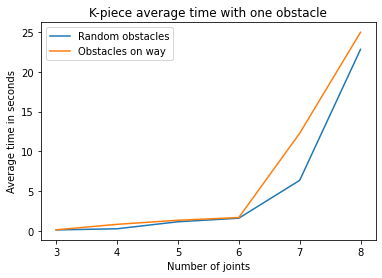

In [20]:
plt.plot(joint_nums, kpiece_rand_obs_joint_num, label='Random obstacles')
plt.plot(joint_nums, kpiece_on_way_obs_joint_num, label='Obstacles on way')
plt.title('K-piece average time with one obstacle')
plt.xlabel('Number of joints')
plt.ylabel('Average time in seconds')
plt.legend()
plt.show()

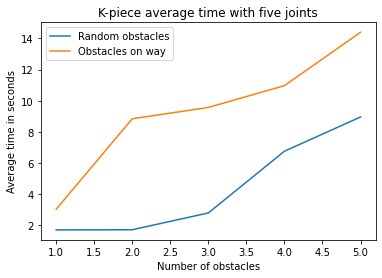

In [21]:
plt.plot(obstacle_nums, kpiece_rand_obs_obstacles_num, label='Random obstacles')
plt.plot(obstacle_nums, kpiece_on_way_obs_obstacles_num, label='Obstacles on way')
plt.title('K-piece average time with five joints')
plt.xlabel('Number of obstacles')
plt.ylabel('Average time in seconds')
plt.legend()
plt.show()

## Conclusion:

`A*` and `RRT` becomes too slow on fairly small tests. `KPIECE` is significantly faster and we can do the following observations for it: 
1. with a fixed number of obstacles, as number of joints increases, the running time grows exponentially
2. with a fixed number of joints, as number of obstacles increases, the running time grows linearly